# PCBF-SF for the Linear System

This Notebooks contains the reimplementation of the safety filter with recovery mechanism for the linear system presented in the paper:

*Wabersich, K.P. and Zeilinger, M.N., 2022. Predictive control barrier functions: Enhanced safety mechanisms for learning-based control. IEEE Transactions on Automatic Control.*

In `apcbf/pcbf_linear.py` a standalone version of the algorithm can be found.

In [ ]:
""" Copyright (c) 2023, ETH Zurich, 
Alexandre Didier*, Robin C. Jacobs*, Jerome Sieber*, Kim P. Wabersich°, Prof. Dr. Melanie N. Zeilinger*, 
*Institute for Dynamic Systems and Control, D-MAVT
°Corporate Research of Robert Bosch GmbH
All rights reserved."""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pytope import Polytope
import cvxpy as cp
import apcbf.simulation as sim
from apcbf.dynamic import LinearDiscreteDynamics
from apcbf.controller import *
import apcbf.simulation as sim
import casadi

In [2]:
# Plotting settings
save_fig = False
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [15, 10]

#### Define System

In [3]:
A = np.mat([[1.05, 1],[0, 1]]) 
B = np.mat([[1,],[0.5,]])

In [4]:
lin_sys = LinearDiscreteDynamics(A, B)
print(lin_sys)

LinearDiscreteDynamics(
 A: [[1.05 1.  ]
 [0.   1.  ]], 
 B: [[1. ]
 [0.5]])


In [5]:
# initial condition
x0 = np.array([-0.1,3])
N_steps = 20

#### Constraints

In [6]:
Hx = np.kron(np.eye(A.shape[0]),np.array([[1],[-1]]))
hx = np.ones((2*A.shape[0],1))
X = Polytope(Hx, hx)
Hu = np.array([[1],[-1]])
hu = np.ones((B.shape[0],1))
U = Polytope(Hu, hu)

constraint_color = (0, 120.0/256, 148.0/256)
# X.plot(alpha=0.4, edgecolor='k',color=(0, 120.0/256, 148.0/256))
# plt.xlim([-1.5,1.5])
# plt.ylim([-1.5,1.5])
# plt.grid()

#### Terminal Control Barrier Function Design

**Step 1**

In [7]:
N = 20

c = 0.001
#Note the plots in the current iteration of the paper are created using the values without sqrt,
# resulting in a different gamma_x (2e-5), P, K than stated in the paper.
mu_x = np.sqrt(0.001) 
mu_u = np.sqrt(0.001)

alpha_f = 1000 # Need to check if Df\int(X_{N-1}(0)) not empty then can choose alpha_f arbitrary large

delta_i = lambda i : i*0.005 #as done in example

In [8]:
n = lin_sys.state_dim
m = lin_sys.input_dim

E = cp.Variable((n, n), symmetric=True) # Pinv, PSD could also be set to true ?
Y = cp.Variable((m, n)) # K*P

obj = cp.Minimize(-cp.log_det(E))

constraints = [E >> 0] 
constraints += [cp.bmat([[E, E@(A.T) + Y.T@(B.T), E@np.eye(n)*(mu_x), Y.T@np.eye(m)*(mu_u)], # TODO check if mu_u is correctly inserted here
                         [(E@(A.T) + Y.T@(B.T)).T, E, np.zeros((n,n)), np.zeros((n,m))],
                        [(E@np.eye(n)*mu_x).T, np.zeros((n,n)), np.eye(n), np.zeros((n,m))],
                        [(Y.T@np.eye(m)*mu_u).T, np.zeros((m,n)), np.zeros((m,n)), np.eye(m)]]) >> 0] # or >=?

constraints += [cp.bmat([[cp.reshape(U.b[i,:]**2,(1,1)), cp.reshape(U.A[i,:]@Y,(1, lin_sys.state_dim))],[cp.reshape(Y.T@(U.A[i,:].T), (lin_sys.state_dim,1)) , E]]) >> 0 for i in range(U.b.shape[0])]

In [9]:
prob = cp.Problem(obj, constraints)
prob.solve(cp.MOSEK, verbose=False)
#prob.solve(cp.SCS, verbose=False) #comment out if MOSEK is unavailable

-7.896638586866642

In [10]:
P = np.linalg.inv(E.value)
K = Y.value @ P
Pinv = E.value

In [11]:
K

array([[-0.06214323, -0.2877949 ]])

In [12]:
P

array([[0.00696194, 0.01496097],
       [0.01496097, 0.08558288]])

Compute $\gamma_x$

In [13]:
# Typo in paper : squared missing
support_values = [(X.b[j,:] - delta_i(N-1))**2 * 1.0/(X.A[j,:]@Pinv@(X.A[j,:].T)) for j in range(X.b.shape[0])]
#print(support_values)
min_support_value = min(support_values)[0]
gamma_x = min(1-c, min_support_value)

In [14]:
gamma_x

0.0035599483847986325

In [15]:
print(Pinv)

[[230.0665379  -40.21854551]
 [-40.21854551  18.71529129]]


**Step 2**

Note the following test may only be necessary for nonlinear systems

In [16]:
def test_gamma_x(gamma):
    success = False
    
    opti = casadi.Opti()
       
    x_stp2 = opti.variable(n)
    x_next = (lin_sys.A + lin_sys.B@K)@x_stp2
    #x_next = sim.simulate_discrete(x_stp2, sys, Nsteps=1, controller_object=K_ctrl) #TODO gets stuck
    obj_stp2 = (-x_next.T @ P @ x_next + gamma)
    
        
    constraint_stp2 = x_stp2.T @ P @ x_stp2 - gamma <= 0
    # could also use norm(cholesky(P)x) <= 0may have better numerical properties
            
    opti.minimize(obj_stp2)
    opti.subject_to(constraint_stp2)
    opti.solver('ipopt')
    
    # if want no output of solver :
    #opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    #opti.solver('ipopt', opts)
    
    sol = opti.solve()
    
    print(-sol.value(obj_stp2))
    if -sol.value(obj_stp2) <= 0 :
        success = True
    else :
        print("Not smaller equal 0")

    return success
    

In [17]:
def test_and_decrease_gamma_x(gamma):
    max_iter = 2
    gamma_decrease = 0.5*1e-5
    success = False
    it = 0
    #K_ctrl = LinearController(K)
    while not success :
        print(f"Try : {it}")
        #print(gamma)
        success = test_gamma_x(gamma)
        if success :
            print("Found gamma_x which ensures invariance")
            print(gamma)
            break
        elif it > max_iter :
            print(f"Max iteration limit {max_iter} reached")
            break
        elif not success :
            gamma -= gamma_decrease
            it += 1
    return gamma

In [18]:
gamma_x = test_and_decrease_gamma_x(gamma_x)

Try : 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number

**Step 3** 

In [19]:
gamma_f = 1 - gamma_x
print(gamma_f)

0.9964400516152013


In [20]:
def test_gamma_f(gamma_x, gamma_f):
    success = False
    
    opti = casadi.Opti()
    
    x_stp3 = opti.variable(n)
    x_next = (lin_sys.A + lin_sys.B@K)@x_stp3
    # x_next = sim.simulate_discrete(x_stp3, sys, Nsteps=1, controller_object=K) #TODO gets stuck
    obj_stp3 = x_next.T @ P @ x_next - x_stp3.T @ P @ x_stp3
    
    # cannot not solve strict
    constraint_stp3 = [0 < x_stp3.T @ P @ x_stp3 - gamma_x, x_stp3.T @ P @ x_stp3 - gamma_x <= gamma_f]
    # could also use norm(cholesky(P)x) <= 0 may have better numerical properties
    
    opti.minimize(-obj_stp3)
    opti.subject_to(constraint_stp3)
    opti.solver('ipopt')
    
    # Use Initial Guess
    opti.set_initial(x_stp3,np.linspace(-2,2,2))
    
    # if want no output of solver :
    #opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    #opti.solver('ipopt', opts)
    
    try :
        sol = opti.solve()
        
        if sol.value(-obj_stp3) < 0 :
            success = True
        else :
            print(f"{sol.value(-obj_stp3)} is not smaller zero")
        
    except :
        sub_opt_value = opti.debug.value(-obj_stp3)
        print(sub_opt_value)
        print(f"TODO investigage what to do in this case may need to extend initial guess from above to more values also random warm starts ?")
    #print(sol.value(x_stp3))
    

        
    return success

In [21]:
print(test_gamma_f(gamma_x, gamma_f))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [22]:
gamma_x, gamma_f

(0.0035599483847986325, 0.9964400516152013)

#### Plot terminal set

In [23]:
P_pap = np.matrix([[0.007, 0.015],[0.015, 0.086]])
gamma_x_pap = 0.0035

@np.vectorize
def quadratic_paper(x1,x2, gammas):
    z = np.array([x1,x2]).reshape((2,1))
    return z.T @ P_pap @ z - gammas

In [24]:
@np.vectorize
def quadratic(x1,x2, gammas):
    z = np.array([x1,x2]).reshape((2,1))
    return z.T @ P @ z - gammas

Plot terminal safe set and compare it to the one computed in the paper

(<matplotlib.patches.Polygon at 0x7f885cd09100>,
 <matplotlib.patches.Polygon at 0x7f8838ef8730>)

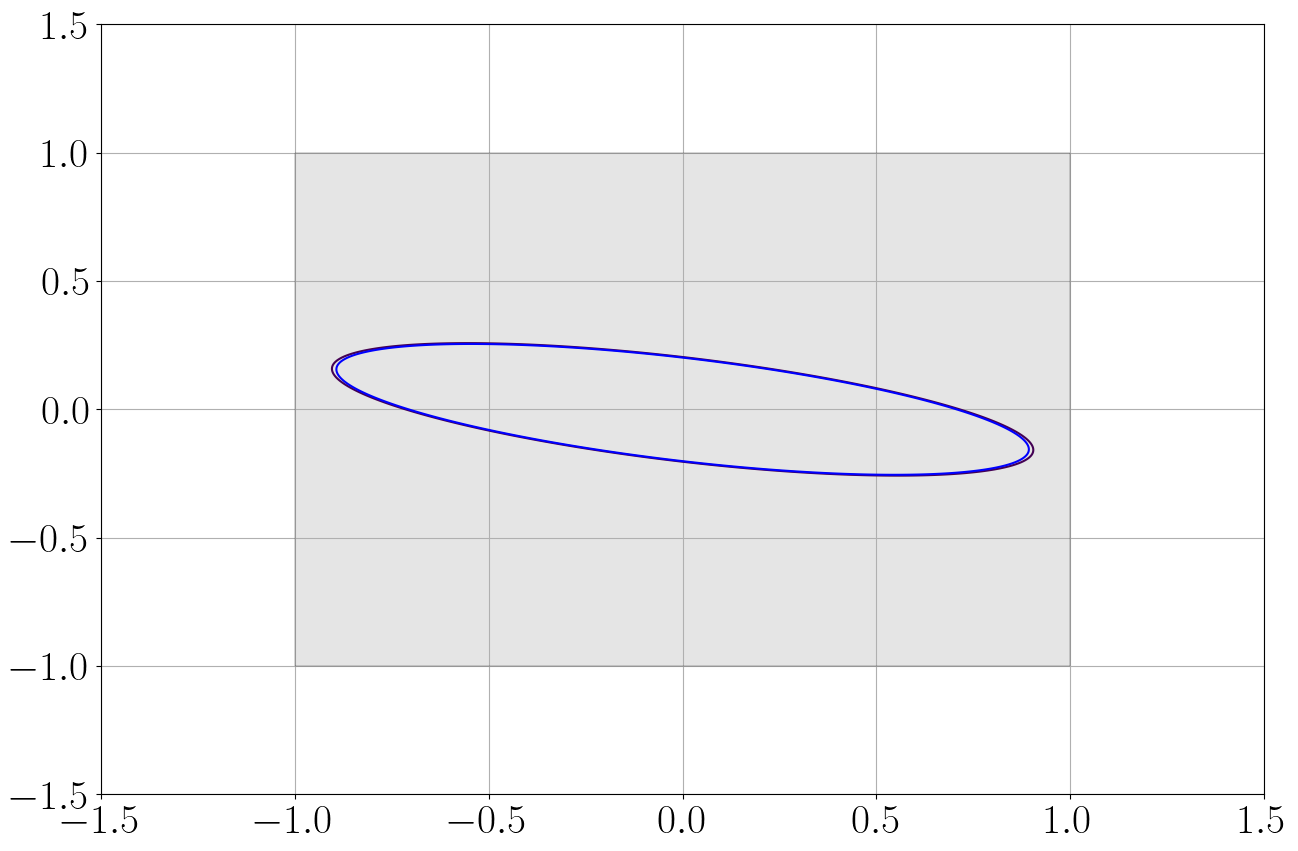

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.linspace(-1,1,500)# *10  # to plot D_f
x2 = np.linspace(-1,1,500)# *10

x1,x2 = np.meshgrid(x1,x2)

z_sf = quadratic(x1,x2, gamma_x)
z_df = quadratic(x1,x2, gamma_x + gamma_f)

cs_sf = plt.contour(x1,x2,z_sf,[0])
#cs_df = plt.contour(x1,x2,z_df,[0],colors='red')
#cs_sf.collections[0].set_label("S_f")


# Plot safe set from paper example (linear,unstable)
z_sf_paper = quadratic_paper(x1,x2, 0.0035)
cs_sf_paper = plt.contour(x1,x2,z_sf_paper,[0], colors='blue')


plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

plt.grid()
#plt.legend()

X.plot(facecolor='grey', alpha=0.2, edgecolor='k', linewidth=0.2)
#plt.legend()

Note : The computed safe set touches the the tightened boundaries $x_1 = \pm | 1 - \Delta_{N-1}| = 1 - 0.095 = 0.905$

### Save parameters

## PCBF-SF

#### Step 1: Computing the optimal slack variables

In [26]:
#OPTIMIZER = cp.SCS
OPTIMIZER = cp.ECOS
#OPTIMIZER = cp.MOSEK

In [27]:
class PCBF_OPT():
    def __init__(self, lin_sys, delta_i, alpha_f, P_f, gamma_x, N=20, verbose=False, tol=1e-6):
        self.N = N
        self.verbose = verbose
        self.constraint_tol = tol
        
        A = lin_sys.A
        self.n = lin_sys.state_dim
        B = lin_sys.B
        self.m = lin_sys.input_dim
        
        # Define the optimization variables
        self.x0 = cp.Parameter((self.n,1))
        self.x = cp.Variable((self.n,self.N+1))
        self.u = cp.Variable((self.m, self.N))
        self.gsi = cp.Variable((X.b.shape[0], self.N))
        self.gsi_N = cp.Variable()
        
        u_shape = (m,1)
        x_shape = (n,1)
        
        # Objective
        self.obj = cp.Minimize(alpha_f*self.gsi_N + sum(cp.norm(self.gsi, axis=0))) # Use 2-norm
        
        # Constraints
        self.constraints = [cp.reshape(self.x[:,0], x_shape) == self.x0]
        
        for t in range(self.N):
            self.constraints.append(self.x[:,t+1] == A@self.x[:,t] + B@self.u[:,t])
            self.constraints.append(X.A@cp.reshape(self.x[:,t],x_shape) <= X.b - delta_i(t)*np.ones(X.b.shape) + cp.reshape(self.gsi[:,t], X.b.shape) - self.constraint_tol) # tightening + relaxation + tolerance
            self.constraints.append(U.A@cp.reshape(self.u[:,t],u_shape) <= U.b - self.constraint_tol)
            self.constraints.append(self.gsi[:,t] >= 0) # TODO check if also need constraint tol here
        
        # Terminal constraints
        self.constraints.append(self.gsi_N >= 0) # TODO check here too
        self.constraints.append(cp.quad_form(self.x[:,self.N], P_f) - gamma_x <= self.gsi_N - self.constraint_tol) # TODO check if also necessary here to tighten
        
        # Problem definition
        self.problem = cp.Problem(self.obj, self.constraints)
        
    def solve(self, x):
        self.x0.value = x.reshape((self.n,1))
        
        if OPTIMIZER == cp.MOSEK :
            #import mosek
            #self.problem.solve(OPTIMIZER, verbose=False, mosek_params={mosek.dparam.intpnt_co_tol_pfeas : 1e-10})
            self.problem.solve(OPTIMIZER, verbose=self.verbose)
        else :
            self.problem.solve(OPTIMIZER, verbose=self.verbose) #, save_file='dump.opf')
        
        if self.problem.status not in ["infeasible", "unbounded"]:
            if self.verbose > 0 :
                print("Found optimal slack variables")
            return self.gsi.value, self.gsi_N.value, self.problem.value
        else :
            print("infeasible :", self.problem.status)
            raise Exception()

In [28]:
slack_opt = PCBF_OPT(lin_sys, delta_i, alpha_f, P, gamma_x)
gsi, gsi_N, opt_value = slack_opt.solve(x0)

In [29]:
print(f"h_pb={slack_opt.problem.value}")
print(f"u ={slack_opt.u.value}")
print(f"gsi = {gsi}")
print(f"gsi_N = {gsi_N}")

h_pb=31.045482840638964
u =[[-0.999999   -0.999999   -0.999999   -0.999999   -0.999999   -0.999999
  -0.999999   -0.999999   -0.999999    0.80879171  0.59348826  0.46104494
   0.39102309  0.29637654  0.19780543  0.11868603  0.06592838  0.0348066
   0.01842356  0.01195535]]
gsi = [[3.28574734e-05 9.00002001e-01 2.49975355e+00 3.67924318e+00
  4.41745779e+00 4.69233363e+00 4.48070376e+00 3.75824289e+00
  2.49940949e+00 6.77384913e-01 7.28003225e-02 1.30839453e-09
  1.30849466e-09 1.30852212e-09 1.30853176e-09 1.30852635e-09
  1.30851431e-09 1.30850226e-09 1.30849390e-09 1.30849235e-09]
 [3.28569166e-05 3.30914695e-05 4.10292337e-05 4.81609138e-05
  5.25103717e-05 6.40205035e-05 6.36722053e-05 5.43799831e-05
  3.95061172e-05 2.33038906e-05 1.00270712e-05 1.30805009e-09
  1.30844171e-09 1.30846607e-09 1.30847320e-09 1.30848776e-09
  1.30850489e-09 1.30851941e-09 1.30852879e-09 1.30853068e-09]
 [2.00000100e+00 1.50500150e+00 1.01000200e+00 5.15002504e-01
  2.00031410e-02 6.40246214e-05 6.36

### Step 2: Computing the safety filter problem using the computed slack variables

In [30]:
class PCBF_SFMPC():
    def __init__(self, lin_sys, perf_ctrl, X, U, P_f, gamma_x, N=20, verbose=False):
        self.verbose = verbose
        self.N = N
        A = lin_sys.A
        self.n = lin_sys.state_dim
        B = lin_sys.B
        self.m = lin_sys.input_dim
        self.perf_ctrl = perf_ctrl
        
        # Define optimization variables
        self.x = cp.Variable((self.n,self.N+1))  
        self.u = cp.Variable((self.m, self.N))
        
        # Define parameter values
        self.x0 = cp.Parameter((self.n,1))
        self.ul = cp.Parameter((self.m,1))
        self.gsi = cp.Parameter((X.b.shape[0], self.N))
        self.gsi_N = cp.Parameter()
        
        # Define optimization objective
        self.min_expr = cp.quad_form( (self.ul - cp.reshape(self.u[:,0],(self.m,1))), np.eye(self.m))                     
        self.obj = cp.Minimize(self.min_expr)
         
        x_shape = self.x0.shape
        u_shape = self.ul.shape
        
        # Define constraints
        self.constraints = [cp.reshape(self.x[:,0], x_shape) == self.x0]
        for t in range(self.N):
            self.constraints.append(self.x[:,t+1] == A@self.x[:,t] + B@self.u[:,t])
            self.constraints.append(X.A@cp.reshape(self.x[:,t],x_shape) <= X.b - delta_i(t)*np.ones(X.b.shape) + cp.reshape(self.gsi[:,t], X.b.shape)) # tightening + relaxation
            self.constraints.append(U.A@cp.reshape(self.u[:,t],u_shape) <= U.b)
        
        # Terminal constraints
        self.constraints.append(cp.quad_form(self.x[:,self.N], P_f) - gamma_x <= self.gsi_N )
        self.problem = cp.Problem(self.obj, self.constraints)
    
    def input(self, x, gsi_N, gsi):
        # Get performance controller input
        ul = self.perf_ctrl.input(x)
        success = False
    
        # due to numerical imprecision MOSEK may return slack variables which are slightly negative -> clip them to 0
        if OPTIMIZER is cp.MOSEK:
            if gsi_N < 0 :
                gsi_N = 0        
        
        # Set parameter vlaues
        self.ul.value = ul.reshape((self.m,1))  
        self.x0.value = x.reshape((self.n,1))  
        self.gsi.value = gsi
        self.gsi_N.value = gsi_N
        
        # Solve problem
        self.problem.solve(OPTIMIZER, verbose=self.verbose) #,mosek_params={mosek.iparam.infeas_report_auto : mosek.onoffkey.on})#, save_file='second_opt.opf')
        
        if self.problem.status not in ["infeasible", "unbounded"]:
            if self.verbose :
                print(f" Found : Safe input : {self.u.value[:,0]}, Performance input : {self.ul.value}")
            u = self.u.value[:,0]
            success = True
        else :
            #if self.verbose :
            #print("Problem is infeasible ! This shouldn't happen since found optimal slack variable.., using performance controller instead")       
            #u = ul.reshape((self.m,1)).flatten()
            print(self.problem.status)
            raise Exception()
            
        return u, success

In [31]:
# Use simple linear gain as performance controllre
K = 10*np.ones((1,2))
bad_ctrl = LinearController(K)
test = PCBF_SFMPC(lin_sys, bad_ctrl, X, U, P, gamma_x)
test.input(x0, gsi_N, gsi)

/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(array([-0.99999967]), True)

#### Combining the two steps into one  Algorithm
Named Algorithm 1 in the paper

In [32]:
import time

In [33]:
class Algorithm(Controller):
    def __init__(self, lin_sys, perf_ctrl, X, U, P_f, gamma_x, verbose=False):
        self.slack_opt = PCBF_OPT(lin_sys, delta_i, alpha_f, P, gamma_x, verbose=verbose)
        self.safety_filter = PCBF_SFMPC(lin_sys, perf_ctrl, X, U, P_f, gamma_x, verbose=verbose)
        self.performance_controller = perf_ctrl
        self.verbose = verbose
        self.hpb_traj = []
        
    def input(self, x):
        if self.verbose :
            print(f"@x={x}")
            now = time.time()
        # Step 1: Compute optimal slack variables 
        gsi, gsi_N, hbp = self.slack_opt.solve(x)
        self.hpb_traj.append(hbp) 
        # Step 2: Use optimal slack variables in safety filter optimization problem
        u, success = self.safety_filter.input(x, gsi_N, gsi)
        
        if self.verbose :
            later  = time.time()
            time_diff = later - now
            print(f'Took {time_diff:.4f} seconds for computing next input')
        return u
    
    def reset(self):
        self.hpb_traj = []

## Simulation

#### Single trajectory

In [34]:
N_steps = 50
K = 10*np.ones((1,2))
x0 = np.array([-3.0, 3])
#x0 = np.array([-20, 0])
#x0 = np.array([0, -6])
bad_ctrl = LinearController(K)
algo =  Algorithm(lin_sys, bad_ctrl, X, U, P, gamma_x, verbose=False)
x_safe, u_safe = sim.simulate_discrete(x0, lin_sys, controller_object=algo, Nsteps=N_steps)

print(algo.hpb_traj[0])

8.437100185158961


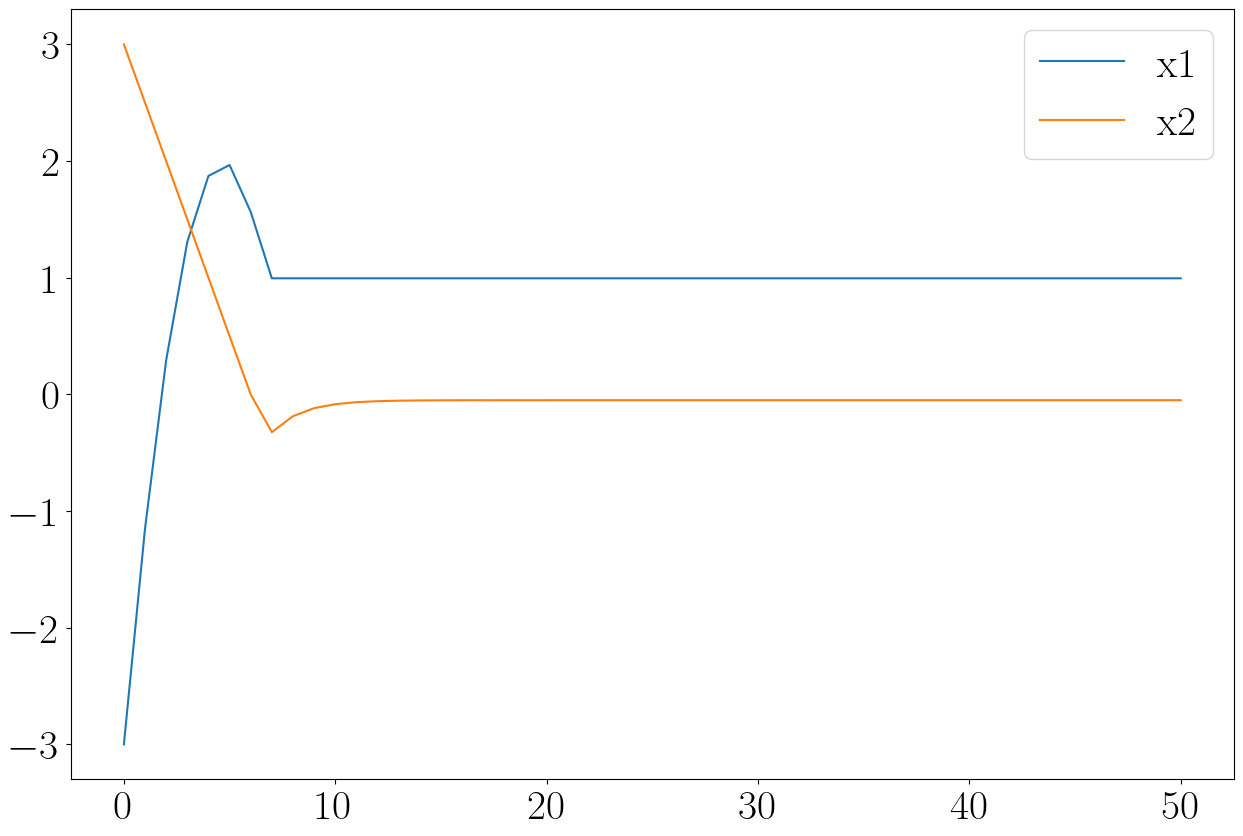

In [35]:
# Plot state trajectories in 1d
t = np.arange(N_steps+1)
plt.plot(t,x_safe[:,0], label = 'x1')
plt.plot(t,x_safe[:,1], label = 'x2')
plt.legend()

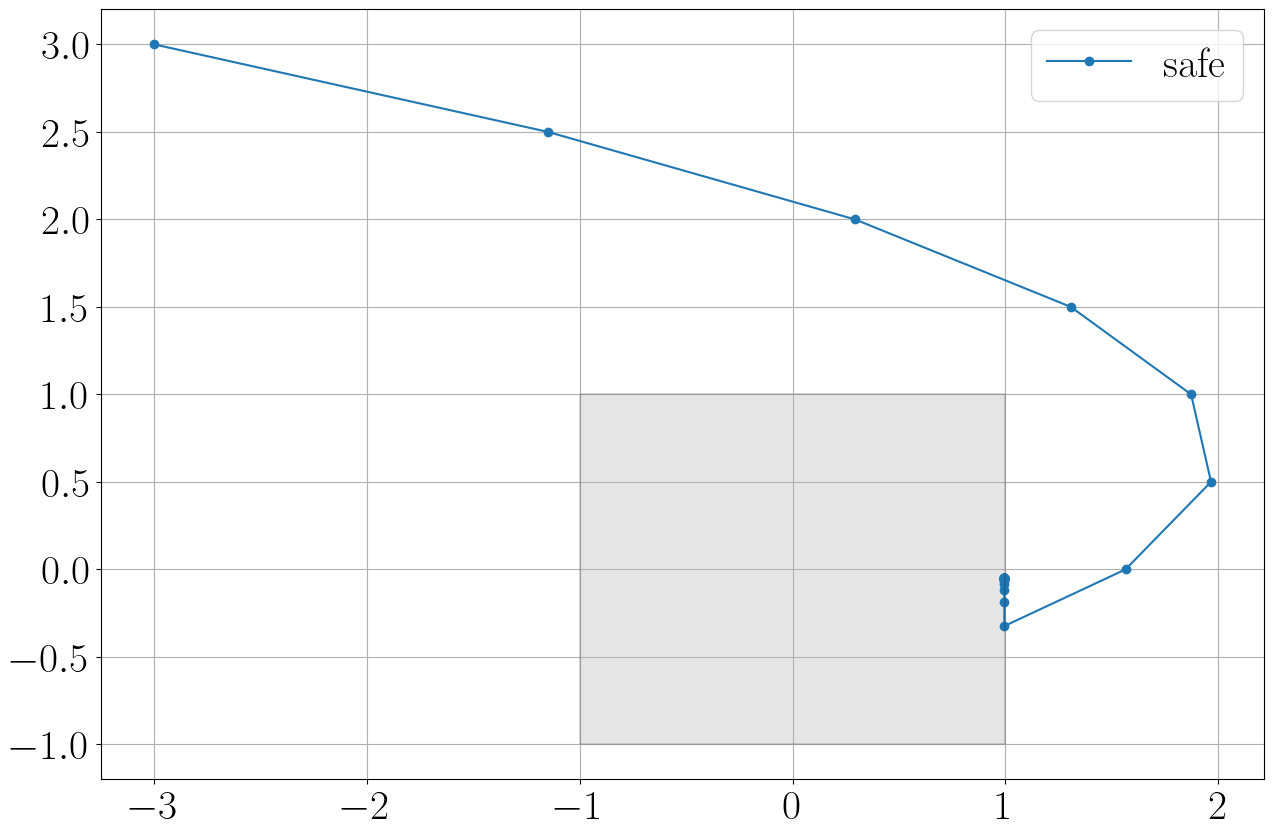

In [36]:
#Plot state trajectories in 2d
plt.plot(x_safe[:,0], x_safe[:,1], '-o',  label = 'safe')
#plt.plot(x_lqr[:,0], x_safe[:,1], '-x', label = 'lqr')
X.plot(facecolor='grey', alpha=0.2, edgecolor='k', linewidth=0.2)
plt.legend()
plt.grid()
#if save_fig :
#plt.savefig(f'plots/svg/one_pcbf_sfmpc_trajectory_at{x0}.svg')

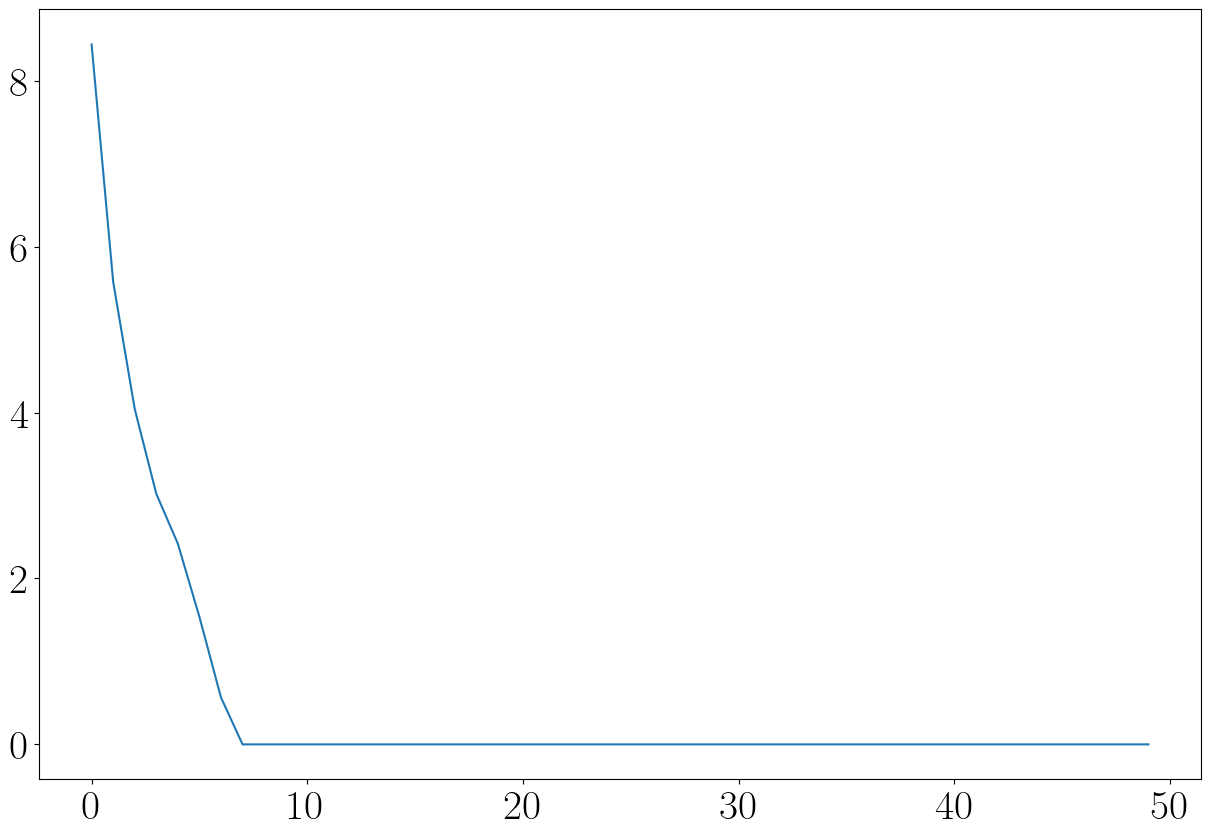

In [37]:
# Plot of hpb_traj 
t = np.arange(N_steps)
plt.plot(t,algo.hpb_traj, label = 'x1')

#### Multi ICs Simulation
Use the Algorithm 1 for intial conditions on a grid of $5 \times 5 $ points

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/pytope/polytope.py:381: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  h_patch.append(ax.add_patch(Polygon(V_sorted, **temp_dict)))
/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/pytope/polytope.py:386: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  h_patch.append(ax.add_patch(Polygon(V_sorted, **temp_dict)))


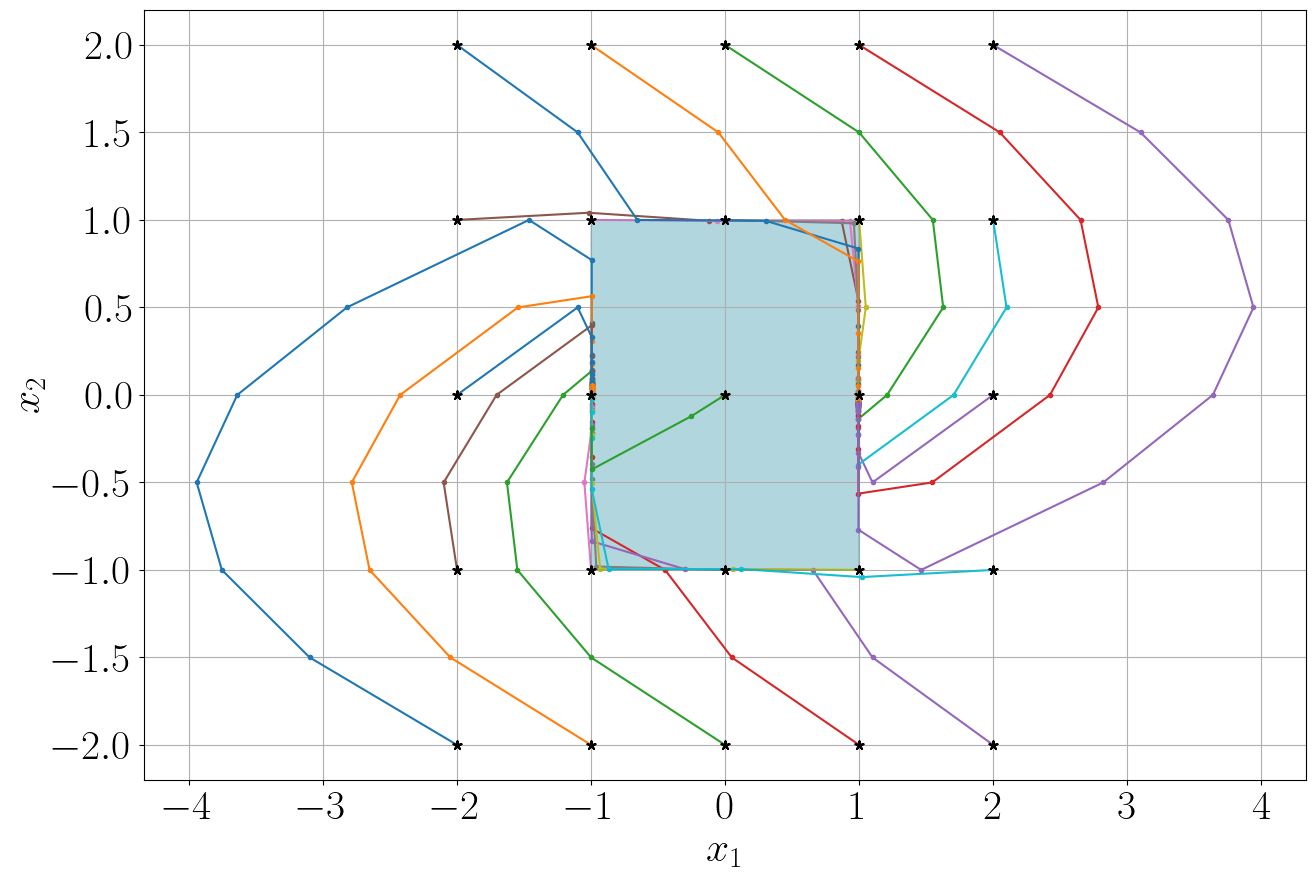

In [38]:
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 5
x1 = np.linspace(-2,2,n_points)
x2 = np.linspace(-2,2,n_points)
x1,x2 = np.meshgrid(x1,x2)
algo =  Algorithm(lin_sys, bad_ctrl, X, U, P, gamma_x, verbose=False)
hpb = np.zeros((len(x1), len(x2)))

numb_infeasible = 0
failure_pts = []
h_traj = []

for j in tqdm(range(len(x1))):
    for k in tqdm(range(len(x2)), leave = False):
        try :
            x_safe, u_safe = sim.simulate_discrete(np.array([x1[j,k], x2[j,k]]), lin_sys, controller_object=algo, Nsteps=20, verbose=False)
            # Check if terminal state has reached constraints otherwise don't plot
            #if np.all(X.A @ x_safe[-1,:] <= X.b) :
            # Check if are in domain D_BP
            if algo.hpb_traj[0] < gamma_f*alpha_f :
                plt.plot(x_safe[:,0], x_safe[:,1], '-o', markersize=3,  label = 'safe')
                plt.scatter(x1[j,k], x2[j,k],marker=(5, 2), color='k', zorder=100)
                hpb[j,k] = algo.hpb_traj[0]
                h_traj.append(algo.hpb_traj)
            algo.reset()
        except Exception as e:
            print(e)
            algo.reset()
            numb_infeasible += 1
            x_failure = x1[j,k], x2[j,k]
            print(x1[j,k], x2[j,k])
            failure_pts.append(np.array([x1[j,k], x2[j,k]])) 

X.plot(facecolor='grey', alpha=0.3, edgecolor='k', color = constraint_color,  linewidth=0.2)
#plt.legend()
plt.grid()
#plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

if numb_infeasible > 0 :
    print(f"Number of infeasible/failure points : {numb_infeasible}")
#trajectories = [sim.simulate_discrete(np.array([x1,x2]), lin_sys, controller_object=algo, Nsteps=N_steps) for x1,x2 in zip(x1,x2)]
#if save_fig :
#plt.savefig(f'plots/pdf/linear_trajectories_pcbf_sfmpc_box2_{n_points}pts.pdf', bbox_inches='tight')

In [39]:
hpb.max()

14.302416376807422

#### Plot CBF $h_{PB}$ trajectory along individual state trajectories

In [40]:
h_traj = np.array(h_traj)

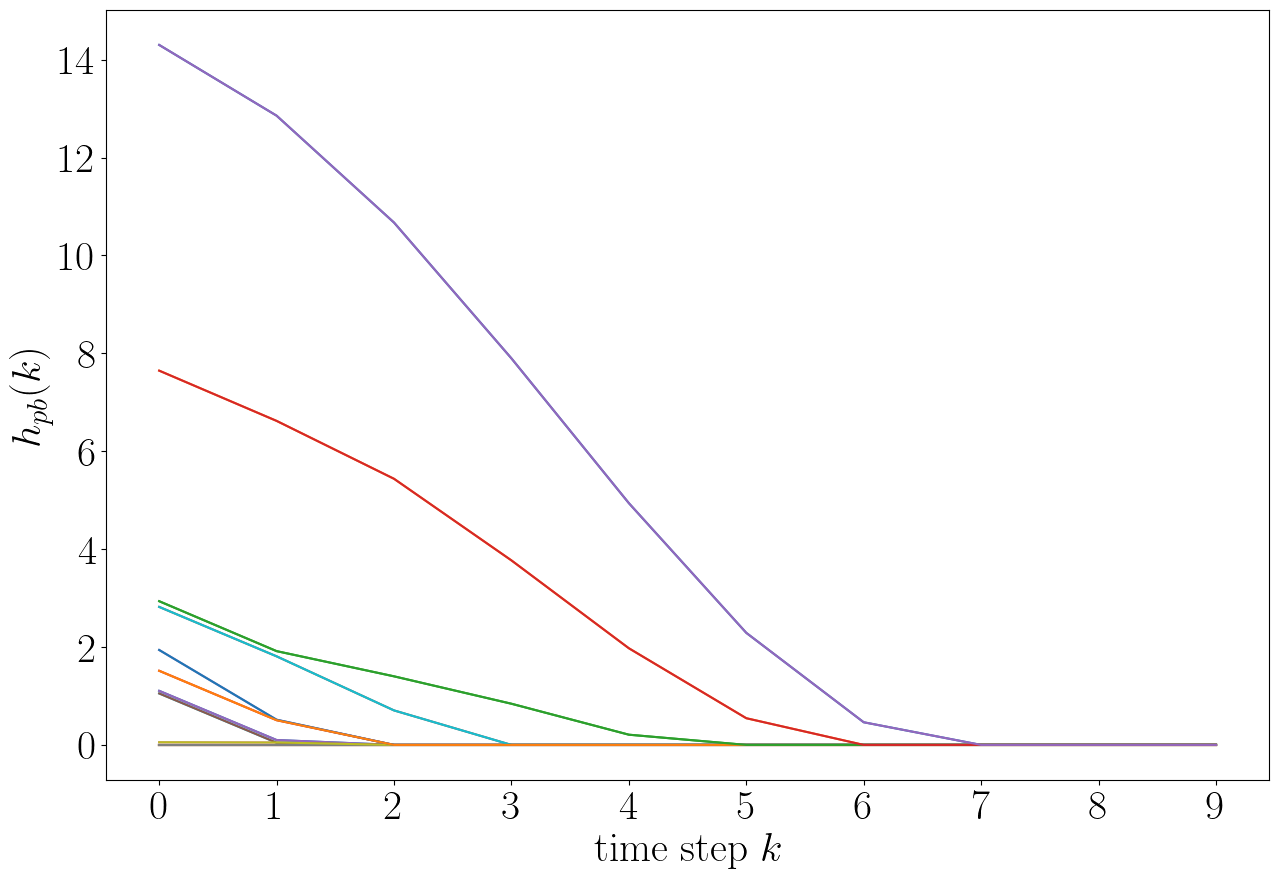

In [41]:
from matplotlib.ticker import MaxNLocator
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)

ax = plt.figure().gca()

for i in range(len(h_traj)) :
    ax.plot(h_traj[i][:10])
plt.xlabel('time step $k$')
plt.ylabel('$h_{pb}(k)$')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.grid()

#if save_fig :
#plt.savefig(f'plots/pdf/linear_multiple_hbp_traj_function_of_steps.pdf', bbox_inches='tight')

#### Plot domain of $h_{\mathrm{PB}}$

In [42]:
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 50 # per dimension
x1 = np.linspace(-1.5,1.5,n_points)
x2 = np.linspace(-1.5,1.5,n_points)
x1,x2 = np.meshgrid(x1,x2)
pcbf =  PCBF_OPT(lin_sys, delta_i, alpha_f, P, gamma_x, verbose=False)
hpb = np.zeros((len(x1), len(x2)))
h_ind = np.zeros((len(x1), len(x2)))
#x_safe, u_safe = sim.simulate_discrete(x0, lin_sys, controller_object=algo, Nsteps=N_steps)

numb_infeasible = 0
failure_pts = []

for j in tqdm(range(len(x1))):
    for k in tqdm(range(len(x2)), leave = False):
        _, _, hpb[j,k] = pcbf.solve(np.array([x1[j,k],x2[j,k]])) 
        #if hpb[j,k] < gamma_f*alpha_f :
        #    h_ind[j,k] = 1

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Plot contour of $h_{\mathrm{PB}}$

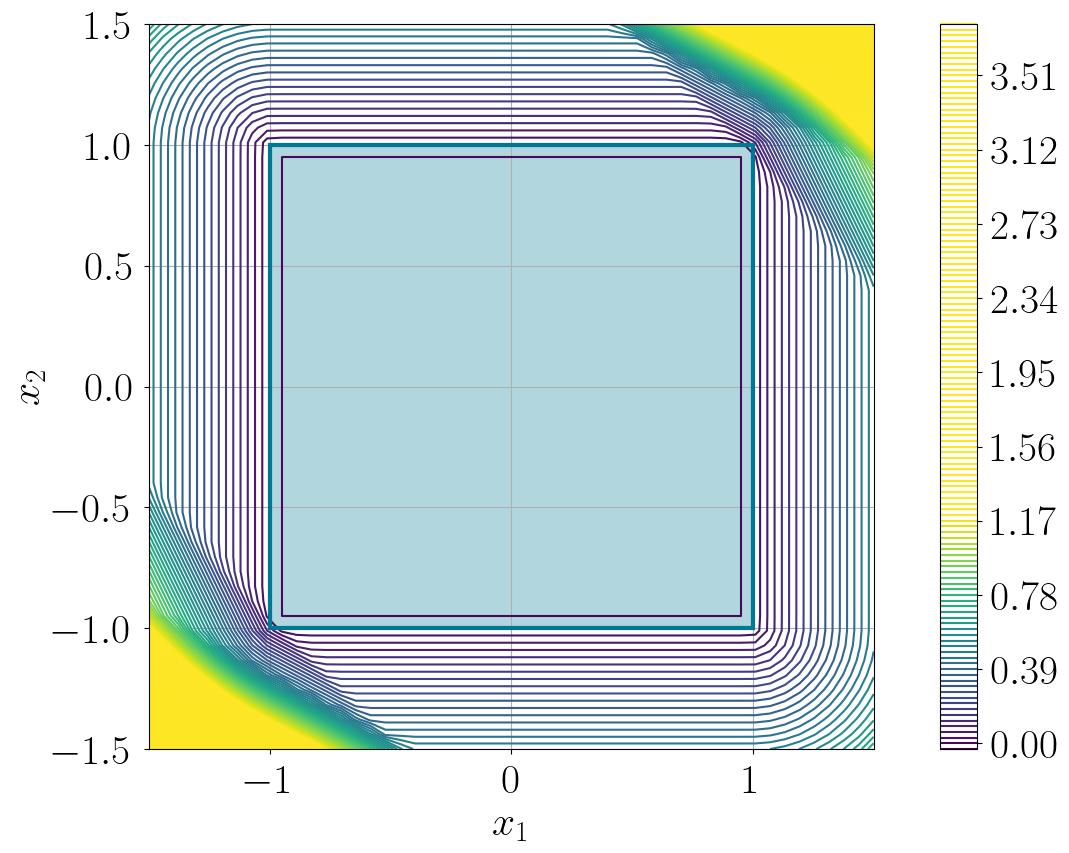

In [43]:
CS = plt.contour(x1, x2, hpb, levels = 150, vmax=1.2)
X.plot(facecolor='red', alpha=0.3, edgecolor='black', color=constraint_color, linewidth=3.0, zorder=100)
plt.grid()
plt.xlabel('$x_1$')#, fontsize=12)
plt.ylabel('$x_2$')
plt.axis('square')

cb = plt.gcf().colorbar(CS)
plt.gca().tick_params(axis='both', which='major', pad=7)
cb.ax.tick_params(axis='both', which='major', pad=7)
plt.tight_layout(pad = 2)
#cs_sf = plt.contour(x1,x2,h_ind,[0.9])
#if save_fig :
#plt.savefig(f'plots/pdf/linear_h_pb_contour_and_constraints_lines_square_{n_points}pts_vmax_1pt_2.pdf', bbox_inches='tight')

Plot zoomed in version of contour of $h_{PB}$

/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/pytope/polytope.py:381: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  h_patch.append(ax.add_patch(Polygon(V_sorted, **temp_dict)))
/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/pytope/polytope.py:386: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  h_patch.append(ax.add_patch(Polygon(V_sorted, **temp_dict)))


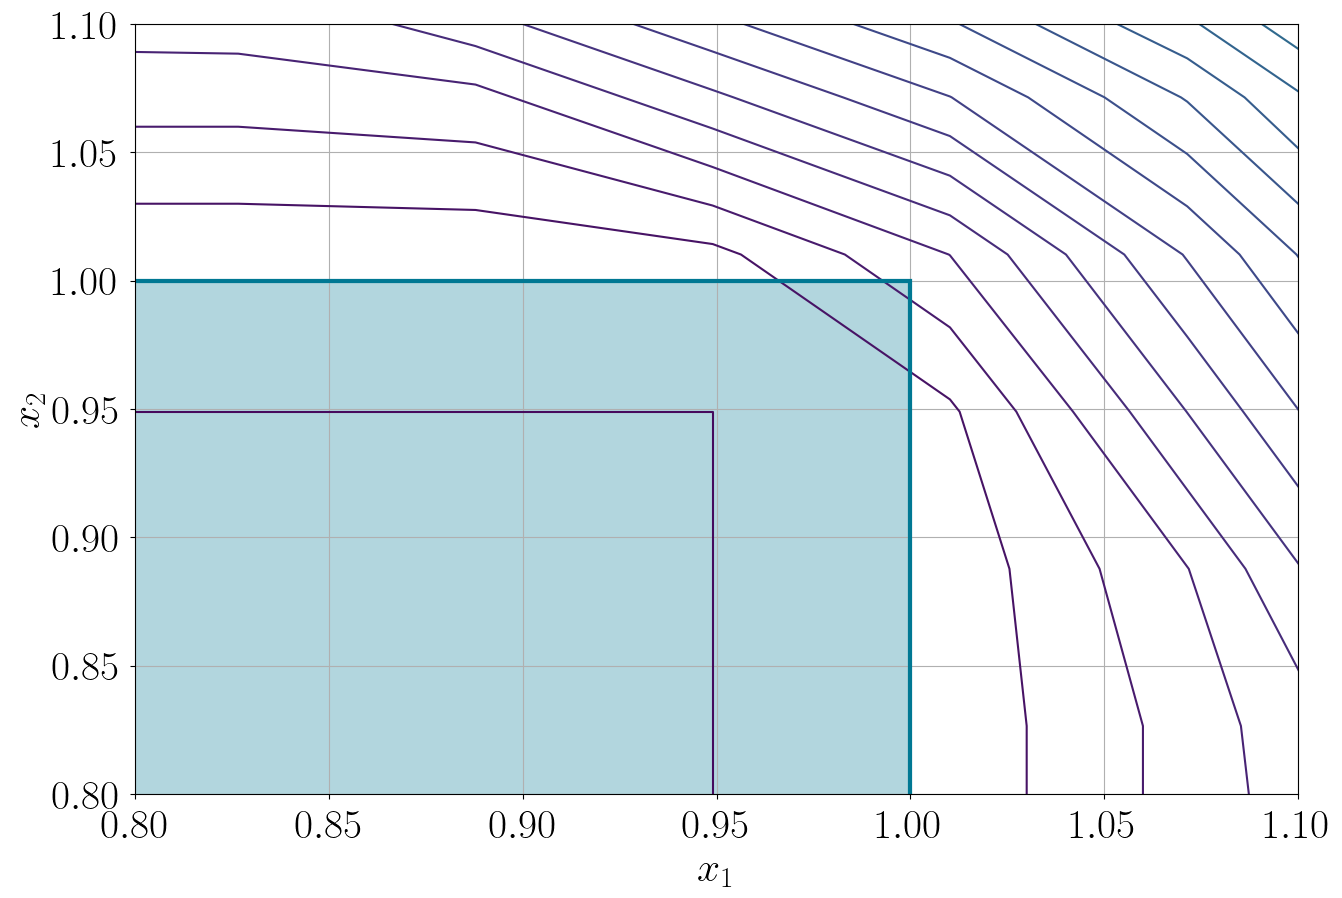

In [44]:
CS = plt.contour(x1, x2, hpb, levels = 150, vmax=1.2)
X.plot(facecolor='red', alpha=0.3, edgecolor='black', color=constraint_color, linewidth=3.0, zorder=100)
plt.grid()
plt.xlabel('$x_1$')#, fontsize=12)
plt.ylabel('$x_2$')
plt.xlim([0.8, 1.1])
plt.ylim([0.8, 1.1])
plt.gca().tick_params(axis='both', which='major', pad=7)
#plt.tight_layout(pad = 2)
#plt.axis('square')
#plt.gcf().colorbar(CS)
#cs_sf = plt.contour(x1,x2,h_ind,[0.9])
#if save_fig :
#plt.savefig(f'plots/pdf/linear_zoom_h_pb_contour_and_constraints_lines_square_{n_points}pts_vmax_1pt_2.pdf', bbox_inches='tight')

### 3D plot of $h_{\mathrm{PB}}$


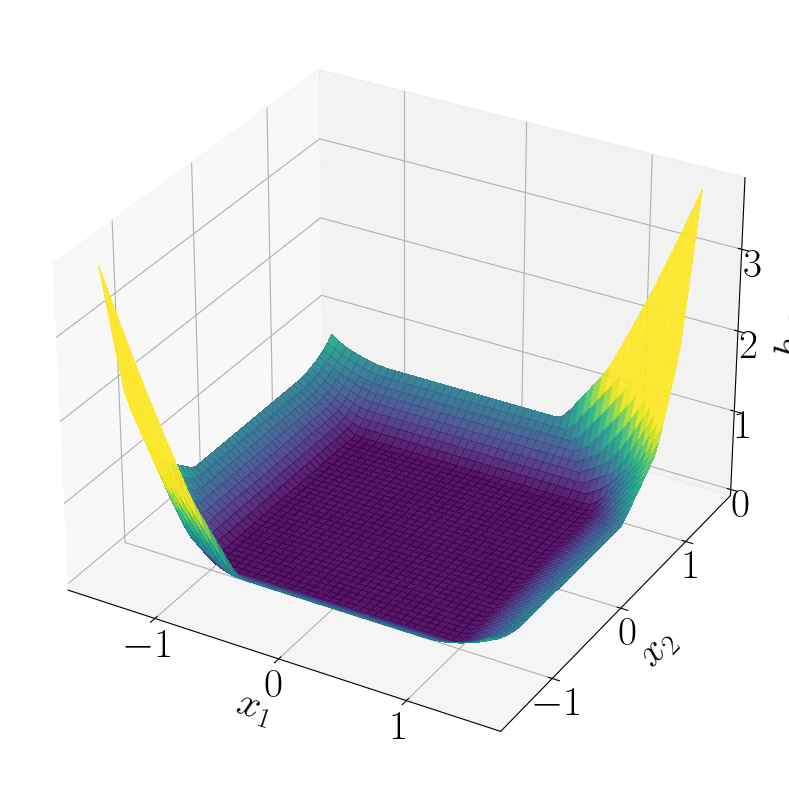

In [45]:
#%matplotlib widget
from matplotlib import cm

# Clipping large values for better visualization
#z_lim = 150
#hpb_mod = np.clip(hpb,a_min = None, a_max= z_lim)
hpb_mod = hpb
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, x2, hpb_mod, cmap=cm.viridis, vmax = 1.2,
                      linewidth=0, alpha=0.9, antialiased=False)
ax.set_xlabel('$x_1$')#, fontsize=15)
ax.set_ylabel('$x_2$')#, fontsize=15)
ax.set_zlabel('$h_{pb}$')#, fontsize=15)
#ax.set_zlim(0, z_lim)

ax.grid('False')
#ax.contour(x1, x2, hpb, zdir='Z', levels=50, offset=0, cmap=cm.viridis, vmax = 1.2, alpha=0.25)
plt.rcParams['xtick.major.pad']='-3'
plt.rcParams['ytick.major.pad']='-3'

#if save_fig:
#plt.savefig(f'plots/eps/h_pb_3d_{n_points}_pts_latex_vmax_1pt_2_no_shadow.eps')
plt.show()